In [1]:
# this line is only used on AWS cluster
print("Welcome to my EMR Notebook!")

Welcome to my EMR Notebook!


In [2]:
# this line is only used on AWS cluster
%%info

UsageError: Cell magic `%%info` not found.


In [ ]:
# this line is only used on AWS cluster
sc.list_packages()

In [4]:
# those lines were only used on AWS cluster
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 
sc.install_pypi_package("matplotlib") #Install matplotlib from given PyPI repository
sc.install_pypi_package("seaborn==0.10.1") #Install seaborn version 0.10.1
sc.install_pypi_package("ipython==7.17.0") #install ipython version 7.17.0

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# this line is only used on AWS cluster
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'SparkContext' object has no attribute 'list_packages'
Traceback (most recent call last):
AttributeError: 'SparkContext' object has no attribute 'list_packages'



In [1]:
# import libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,Window
from pyspark.sql.types import *
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt


In [2]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# session overview
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.driver.host', 'b904597f18a2'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '43947'),
 ('spark.master', 'local[*]'),
 ('spark.app.id', 'local-1598434362042'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [4]:
spark

## Load and Clean Dataset
Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids.

In [5]:
# Load data 
# Read in full sparkify dataset
#user_log = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json" #whole data on cloud
#mini data on cloud
#user_log = "s3://aws-emr-resources-057584263306-eu-central-1/notebooks/e-1DYCDZU9IGL1MSTRN75J0HLSI/mini_sparkify_event_data.json" 
# mini data local
user_log = "mini_sparkify_event_data.json" 
df = spark.read.json(user_log)

In [6]:
def clean_data(df):
    """generate features based on df_clean
    
    Param:
        df: original data set
    
    Return:
        df_clean: data frame with missing userId handeled, timestamp transferred, userAgent and location simplified and extra columns deleted
    """
    
    #droping invalid userIds (empty string IDs might represent the visitors of the website who did not register)
    df_clean = df.filter(df["userId"] != "")     
       
    # create column "state" with Abbreviation of US states extracted from "location" column
    df_clean = df_clean.withColumn('state', trim(split(col('location'),',').getItem(1)))
    
    # convert ts to epoch time and create month, date, hour columns out of it
    df_clean = df_clean.withColumn('epoch_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    df_clean = df_clean.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    
    # simplify "userAgent"
    agent = udf(lambda x: str(re.findall(r'\((.*?)\)', x)[0].split(";")[0].split()[0]) if x is not None else None, StringType())
    df_clean = df_clean.withColumn("agent", agent(df_clean.userAgent))
    
    # drop columns
    df_clean = df_clean.drop('location','auth','firstName','lastName','method','status','userAgent')
    
    return df_clean

In [7]:
def define_churn_downgrade(df_clean):
    """lable churn and downgrade on df_clean
    
    Param:
        df_clean: clean data set
    
    Return:
        df_clean: data frame with churned and downgraded users labeled as "1" and stayed and not downgraded users labeled as "0"
    """
    
    # Using the "Cancellation Confirmation" events to define churn with label 1 and 0 for not
    flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df_clean = df_clean.withColumn("Churn", flag_churn_event("page"))

    # add churn user flag
    df_clean = df_clean.withColumn("label", max('Churn').over(Window.partitionBy('UserId')))
    
    # Flag users who downgraded at least once as 1 and users who never downgraded as 0.
    flag_downgrade_event = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
    df_clean = df_clean.withColumn("Downgrade", flag_downgrade_event("page"))

    # add downgraded user flag
    df_clean = df_clean.withColumn("downgraded", max('Downgrade').over(Window.partitionBy('UserId')))
    
    # delete 'Downgrade','Churn' columns
    df_clean = df_clean.drop('Downgrade','Churn')
    
    return df_clean
    

In [8]:
df_clean = clean_data(df)

In [9]:
df_clean = define_churn_downgrade(df_clean)

In [10]:
df_clean.show(5)

+--------------------+------+-------------+---------+-----+---------+-------------+---------+--------------------+-------------+------+-----+-------------------+----------+------+-----+----------+
|              artist|gender|itemInSession|   length|level|     page| registration|sessionId|                song|           ts|userId|state|         epoch_time|      date| agent|label|downgraded|
+--------------------+------+-------------+---------+-----+---------+-------------+---------+--------------------+-------------+------+-----+-------------------+----------+------+-----+----------+
|Sleeping With Sirens|     F|            0|202.97098| free| NextSong|1538016340000|       31|Captain Tyin Knot...|1539003534000|100010|   CT|2018-10-08 12:58:54|2018-10-08|iPhone|    0|         0|
|Francesca Battist...|     F|            1|196.54485| free| NextSong|1538016340000|       31|Beautiful_ Beauti...|1539003736000|100010|   CT|2018-10-08 13:02:16|2018-10-08|iPhone|    0|         0|
|              

In [11]:
# subset data
df_page = df_clean.select('label','userId','page','date')

## Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [12]:
def prepare_features(df_clean):
    """generate features based on df_clean
    
    Param:
        df_clean: cleaned data frame from which all features are generated
    
    Return:
        df_model: data frame with all necessary features
    """
    
    # add feature "registered days"
    cancellation_df = df_clean.select('userId','ts')\
                              .groupBy('userId')\
                              .agg(max('ts')\
                              .alias('lastinteraction'))
    df_clean = cancellation_df.join(df_clean, on='userId')\
                              .withColumn('registered_days', 
                                          ((col('lastinteraction')-col('registration'))/86400000)
                              .cast(IntegerType()))
    df_clean = df_clean.drop('lastinteraction','registration')
    del cancellation_df
    
    # add feature "latest level of users before they churn"
    level_df = df_clean.select('ts','userId','level')\
                       .orderBy('ts', ascending=False)\
                       .groupBy('userId')\
                       .agg(first('level')\
                       .alias('valid_level'))    
    df_clean = df_clean.drop('level')
    df_clean = df_clean.join(level_df, on='userId')
    del level_df
    
    # add feature "Number of songs per day"
    temp_daily_song = df_clean.select('userId','date','song')\
                              .groupBy('userId','date')\
                              .agg(countDistinct('song')\
                              .alias('songs'))\
                              .sort('userId')
    daily_song = temp_daily_song.groupBy('userId')\
                                .avg('songs')\
                                .withColumnRenamed('avg(songs)',
                                                   'avg_daily_song')
    df_clean = df_clean.join(daily_song, on='userId')
    del temp_daily_song,daily_song
   
    # add feature "Number of songs per session"
    # create new feature
    song_per_session_df = df_clean.select('page','label', 'userId', 'sessionId')\
                                  .where('page == "NextSong"')\
                                  .groupby(['label', 'userId', 'sessionId'])\
                                  .count()\
                                  .groupby(['label', 'userId'])\
                                  .agg({'count': 'avg'})\
                                  .withColumnRenamed('avg(count)', 
                                                     'songs_per_session')
    df_clean = df_clean.join(song_per_session_df.drop('label'), on='userId')
    del song_per_session_df
    
    # add feature "average session duration"
    # session duration for each user
    session_duration = df_clean.select('userId','sessionId','ts')\
                               .groupBy('userId','sessionId')\
                               .agg(((max('ts')-min('ts'))/1000/3600)\
                               .alias('activesession'))
    # average session duration for each user
    session_duration_df = session_duration.groupBy('userId')\
                                          .avg('activesession')\
                                          .withColumnRenamed('avg(activesession)',
                                                             'avg_session')
    # join dataframe to create new column
    df_clean = df_clean.join(session_duration_df, on='userId')
    del session_duration,session_duration_df
    
    # add feature "Friends added"
    # average number of friends added daily
    daily_friends_df = df_page.where('page == "Add Friend"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'friends')
    
    # join dataframe to create new column "friends"
    df_clean = df_clean.join(daily_friends_df.drop('label'), on='userId',how='left')
    del daily_friends_df
    
    # add feature "number of thumb ups"
    # average number of "thumbs up" daily
    thumbs_up_df = df_page.where('page == "Thumbs Up"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'thumbs_ups')

    # join dataframe to create new column "thumbs_ups"
    df_clean = df_clean.join(thumbs_up_df.drop('label'), on='userId',how='left')
    del thumbs_up_df
    
    # add feature "number of "thumbs down"
    # average number of "thumbs down" daily
    thumbs_down_df = df_page.where('page == "Thumbs Down"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'thumbs_downs')
    
    # join dataframe to create new column "thumbs_down"
    df_clean = df_clean.join(thumbs_down_df.drop('label'), on='userId',how='left')
    del thumbs_down_df
    
    # add feature "Times to add to playlist"
    # average number of "add to playlist" 
    add_playlist_df = df_page.where('page == "Add to Playlist"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'add_playlist')
    
    # join dataframe to create new column "add_playlist"
    df_clean = df_clean.join(add_playlist_df.drop('label'), on='userId',how='left')
    del add_playlist_df
    
    # add feature "times to roll advert"
    # average number of "roll advert" 
    roll_advert_df = df_page.where('page == "Roll Advert"').groupby(['label', 'userId','date']).count()\
        .groupby('label','userId').avg('count').withColumnRenamed('avg(count)', 'roll_advert')

    # join dataframe to create new column "roll_advert"
    df_clean = df_clean.join(roll_advert_df.drop('label'), on='userId',how='left')
    del roll_advert_df
    
    # assemble features for modeling
    df_model = df_clean.select(['userId',
                                   'label',
                                   'downgraded',
                                   'gender',
                                   'valid_level',
                                   'agent',
                                   'registered_days',
                                   'avg_daily_song',
                                   'songs_per_session',
                                   'avg_session',
                                   'friends',
                                   'thumbs_ups',
                                   'thumbs_downs',
                                   'add_playlist',
                                   'roll_advert']).dropDuplicates(['userId'])
    
    # format decimal
    df_model = df_model.withColumn("daily_song", bround(df_model.avg_daily_song,1))
    df_model = df_model.withColumn("session_song", bround(df_model.songs_per_session,1))
    df_model = df_model.withColumn("session_duration", bround(df_model.avg_session,1))

    # replace missing value with 0
    df_model = df_model.na.fill(0)
    
    # drop old columns
    df_model = df_model.drop('avg_daily_song','songs_per_session','avg_session','userId')

    return df_model

In [13]:
df_model = prepare_features(df_clean)

In [ ]:
df_model.columns

### Transform features for model fitting

In [14]:
def transform_features(df_model):
    """transfrom the features into the form the model can digest
    
    Param:
        df_model: the data frame with all necessary features.
        
    Return:
        df_model: data data frame ready to be used for modeling.
    """
    
    # Transform categorical columns with StringIndexer
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_model) 
                    for column in ['gender','valid_level','agent'] ]
    pipeline = Pipeline(stages=indexers)
    df_r = pipeline.fit(df_model)\
                   .transform(df_model)
    df_model = df_r.drop('gender','valid_level','agent')
    
    # use StandardScaler to scalerize the created “scaled_feature” column
    # assembeling numeric features to create a vector
    assembler = VectorAssembler(inputCols=['registered_days',
                                           'friends',
                                           'thumbs_ups',
                                           'thumbs_downs',
                                           'add_playlist',
                                           'roll_advert',
                                           'daily_song',
                                           'session_song',
                                           'session_duration'], 
                                outputCol="features")
    
    # use the transform method to transform df
    df_model = assembler.transform(df_model)
    
    # standardize numeric feature vector
    standardscaler=StandardScaler().setInputCol("features")\
                                   .setOutputCol("Scaled_features")
    df_model = standardscaler.fit(df_model)\
                             .transform(df_model)
 
    # Combine all features in one single feature vector
    assembler = VectorAssembler(inputCols=['Scaled_features',
                                           'downgraded',
                                           'gender_index',
                                           'valid_level_index',
                                           'agent_index'],
                                outputCol='exp_features')
    
    # use the transform method to transform df
    df_model = assembler.transform(df_model)
    
    return df_model

In [15]:
df_model = transform_features(df_model)

In [16]:
df_model = df_model.select('label','exp_features')

In [32]:
df_model.show(5,False)

+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|exp_features                                                                                                                                                                              |
+-----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[1.46095433566683,1.0144883259394453,1.454671131687067,1.6091251519374448,1.089964577268406,4.020176858369638,1.2518757615061304,0.922113675073389,0.8826912851795525,0.0,1.0,1.0,2.0]    |
|0    |[1.859396427212329,1.5217324889091681,1.5402400217863064,3.861900364649867,1.245673802592464,0.8117664810169462,1.7609505596633548,1.5133926728303715,1.4937852518423198,1.0,0.0,0.0,2.0] |
|1    |(13,[0,5,6,7,8,11,

In [18]:
df_model.count()

225

In [19]:
df_model.cache()

DataFrame[label: int, exp_features: vector]

## Modeling
Logistic regression, random forest, and gradient boosted tree models were selected to fit the data set. F1 score and AUC (Area Under The Curve) were selected as evaluation metrics. Because our training data is imbalanced (there are less churned than stayed users, and from the perspective of the company, incorrectly identifying a user who was going to churn is more costly. In this case, F1-score is a better metric than the accuracy, because it provides a better measure of the incorrectly classified cases. AUC gives us a perspective over how good the model is regarding the separability, in another word, distinguishing 1 (churn) from 0 (stay).

### Train test split
As a first step break your data set into 80% of training data and set aside 20%. Set random seed to `42`.

In [20]:
rest, validation = df_model.randomSplit([0.8, 0.2], seed=42)
print('The number of training examples are {}'.format(rest.count()))
print('The number of test examples are {}'.format(validation.count()))

The number of training examples are 191
The number of test examples are 34


### Check imbalance in the dataset

In [21]:
dataset_size = float(rest.select('label').count())
numPositives = rest.select('label').where('label == 1').count()
per_ones = (float(numPositives)/float(dataset_size))*100
numNegatives = float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 42
Percentage of ones are 21.98952879581152


### Class weighing

In [22]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.7801047120418848


In [23]:
# creating a new column named “classWeights” in the “rest” dataset
rest = rest.withColumn("classWeights", when(rest.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
rest.select("classWeights").show(5)

+------------------+
|      classWeights|
+------------------+
|0.2198952879581152|
|0.7801047120418848|
|0.2198952879581152|
|0.7801047120418848|
|0.7801047120418848|
+------------------+
only showing top 5 rows



In [24]:
rest.cache()
validation.cache()

DataFrame[label: int, exp_features: vector]

In [35]:
def model_eval(model, train_data, valid_data,verbose=False):
    """Train the model given training data set and evaluate on validation data set and return the evaluation metrics
    
    Param:
        model: the spark machine learning model for classification
        train_data: spark data frame for training data set
        valid_data: spark data frame for validation data set
        verbose: boolean indicator of showing the model result or not
    Return:
        result: a dictionary including F1 score, AUC score and feature importance
    """
    
    fitted_model = model.fit(train_data)

    
    exp_features = ['registered_days',
                    'friends',
                    'thumbs_ups',
                    'thumbs_downs',
                    'add_playlist',
                    'roll_advert',
                    'daily_song',
                    'session_song',
                    'session_duration',
                    'downgraded',
                    'gender_index',
                    'valid_level_index',
                    'agent_index']
    
    predict_rest = fitted_model.transform(train_data)
    predict_val = fitted_model.transform(valid_data)

    #F1 score
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score_rest = f1_score_evaluator.evaluate(predict_rest.select(col('label'), col('prediction')))
    f1_score_val = f1_score_evaluator.evaluate(predict_val.select(col('label'), col('prediction')))

    #AUC
    auc_evaluator = BinaryClassificationEvaluator()
    roc_value_rest = auc_evaluator.evaluate(predict_rest, {auc_evaluator.metricName: "areaUnderROC"})
    roc_value_val = auc_evaluator.evaluate(predict_val, {auc_evaluator.metricName: "areaUnderROC"})
    
    if verbose:
        print('The F1 score on the train set is {:.2%}'.format(f1_score_rest))
        print('The F1 score on the test set is {:.2%}'.format(f1_score_val)) 
        print('The areaUnderROC on the train set is {:.2%}'.format(roc_value_rest))
        print('The areaUnderROC on the test set is {:.2%}'.format(roc_value_val))
    
    ## feature importances
    if isinstance(model, LogisticRegression):
        FI = fitted_model.coefficients
        model_FI = pd.DataFrame(list(zip(exp_features, FI)), 
                                columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)
        if verbose:
            model_FI.plot.bar(x='Feature', y='Coefficient')
            plt.ylabel('Coefficient')
            
    if isinstance(model, RandomForestClassifier) or isinstance(model, GBTClassifier):
        FI = fitted_model.featureImportances
        model_FI = pd.DataFrame(list(zip(exp_features, FI)), 
                                columns=['Feature', 'FeatureImportances']).sort_values('FeatureImportances', ascending=False)
        if verbose:
            model_FI.plot.bar(x='Feature', y='FeatureImportances')
            plt.ylabel('FeatureImportances')
    if isinstance(model,CrossValidator):
        FI = fitted_model.bestModel.featureImportances
        model_FI = pd.DataFrame(list(zip(exp_features, FI)), 
                                columns=['Feature', 'FeatureImportances']).sort_values('FeatureImportances', ascending=False)
        if verbose:
            model_FI.plot.bar(x='Feature', y='FeatureImportances')
            plt.ylabel('FeatureImportances')
    
    if verbose:
        # visualizing fearue importances
        plt.title('Feature importance of'+ str(type(model)))
        plt.xlabel('Features')
        plt.xticks(rotation=45, ha='right')
        plt.show()

    result = {}
    result['f1_score_rest'] = f1_score_rest
    result['f1_score_val'] = f1_score_val
    result['roc_value_rest'] = roc_value_rest
    result['roc_value_val'] = roc_value_val
    result['model_FI']=model_FI
    
    return result

### Logistic regression model

The F1 score on the train set is 74.38%
The F1 score on the test set is 73.10%
The areaUnderROC on the train set is 79.43%
The areaUnderROC on the test set is 76.25%


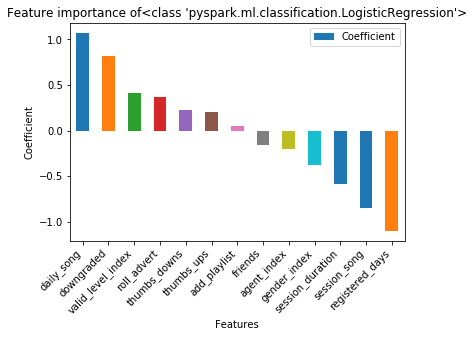

{'f1_score_rest': 0.7438047080348289,
 'f1_score_val': 0.731029253806786,
 'roc_value_rest': 0.7943432406519648,
 'roc_value_val': 0.7625000000000001,
 'model_FI':               Feature  Coefficient
 6          daily_song     1.070573
 9          downgraded     0.813533
 11  valid_level_index     0.417123
 5         roll_advert     0.374592
 3        thumbs_downs     0.224694
 2          thumbs_ups     0.203438
 4        add_playlist     0.052124
 1             friends    -0.152221
 12        agent_index    -0.198234
 10       gender_index    -0.378273
 8    session_duration    -0.582143
 7        session_song    -0.843315
 0     registered_days    -1.095416}

In [36]:
lr = LogisticRegression(labelCol="label", featuresCol="exp_features",weightCol="classWeights",maxIter=10)
result_lr = model_eval(lr, rest, validation, verbose=True)
result_lr

### Random forest model

The F1 score on the train set is 90.21%
The F1 score on the test set is 70.31%
The areaUnderROC on the train set is 98.21%
The areaUnderROC on the test set is 80.00%


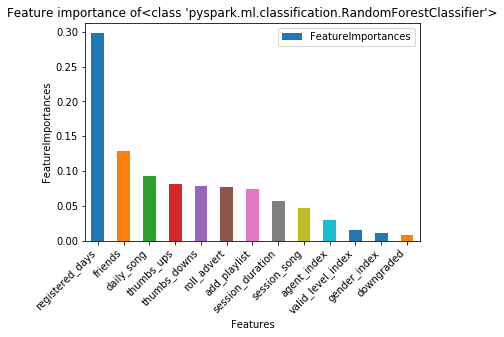

{'f1_score_rest': 0.9021047839833493,
 'f1_score_val': 0.7030812324929971,
 'roc_value_rest': 0.9821029082774048,
 'roc_value_val': 0.7999999999999999,
 'model_FI':               Feature  FeatureImportances
 0     registered_days            0.297731
 1             friends            0.128951
 6          daily_song            0.093057
 2          thumbs_ups            0.080929
 3        thumbs_downs            0.078907
 5         roll_advert            0.077164
 4        add_playlist            0.074675
 8    session_duration            0.057215
 7        session_song            0.046073
 12        agent_index            0.030209
 11  valid_level_index            0.015543
 10       gender_index            0.010930
 9          downgraded            0.008616}

In [37]:
rf = RandomForestClassifier(labelCol="label", featuresCol="exp_features")
result_rf = model_eval(rf, rest, validation, verbose=True)
result_rf

### Gradient boosted tree model

The F1 score on the train set is 99.47%
The F1 score on the test set is 68.04%
The areaUnderROC on the train set is 100.00%
The areaUnderROC on the test set is 64.58%


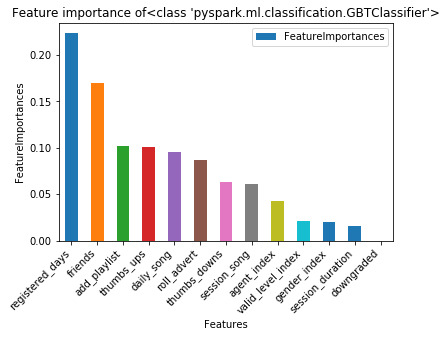

{'f1_score_rest': 0.9947416133215556,
 'f1_score_val': 0.6804298642533937,
 'roc_value_rest': 1.0,
 'roc_value_val': 0.6458333333333334,
 'model_FI':               Feature  FeatureImportances
 0     registered_days            0.223323
 1             friends            0.169686
 4        add_playlist            0.101518
 2          thumbs_ups            0.100753
 6          daily_song            0.095390
 5         roll_advert            0.086766
 3        thumbs_downs            0.062618
 7        session_song            0.060988
 12        agent_index            0.042665
 11  valid_level_index            0.020857
 10       gender_index            0.020020
 8    session_duration            0.015416
 9          downgraded            0.000000}

In [38]:
# Initialize Gradient-Boosted Tree object
gbt = GBTClassifier(labelCol="label", featuresCol="exp_features", maxIter=10)
result_gbt = model_eval(gbt, rest, validation, verbose=True)
result_gbt

### Hyperparameter tuning
Create a parameter grid for tuning the model and perform cross validation. Because of time limitation this step was only done to GBT model, which gave best scores on the former session.

The F1 score on the train set is 87.73%
The F1 score on the test set is 72.74%
The areaUnderROC on the train set is 91.27%
The areaUnderROC on the test set is 78.33%


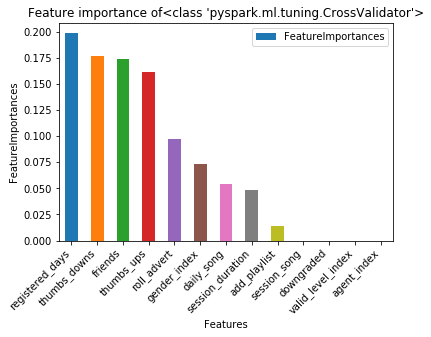

{'f1_score_rest': 0.8772780459172849,
 'f1_score_val': 0.7273576097105509,
 'roc_value_rest': 0.9126717801214443,
 'roc_value_val': 0.7833333333333334,
 'model_FI':               Feature  FeatureImportances
 0     registered_days            0.198739
 3        thumbs_downs            0.176970
 1             friends            0.174326
 2          thumbs_ups            0.162058
 5         roll_advert            0.097549
 10       gender_index            0.073459
 6          daily_song            0.054216
 8    session_duration            0.048580
 4        add_playlist            0.014103
 7        session_song            0.000000
 9          downgraded            0.000000
 11  valid_level_index            0.000000
 12        agent_index            0.000000}

In [39]:
# logistic regression model parameters
lrparamGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

# Create 3-fold CrossValidator
crossval_lr = CrossValidator(estimator=lr,estimatorParamMaps=lrparamGrid,evaluator=evaluator,numFolds=3)
result_cv = model_eval(cv, rest, validation, verbose=True)
result_cv

In [40]:
# for Gradient-Boosted Tree model
#gbparamGrid = (ParamGridBuilder()
#             .addGrid(gbt.maxDepth, [2, 5, 10])
#             .addGrid(gbt.maxIter, [5, 10, 15])
#             .build())

In [42]:

# Create 3-fold CrossValidator
#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="label")
#cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbparamGrid, evaluator=evaluator, numFolds=3)
#result_cv = model_eval(cv, rest, validation, verbose=True)
#result_cv

## Conclusion


In this project, churn prediction was performed based on an event data set for a music streaming provider. This was basically a binary classification problem. After loading and cleaning data, I performed some exploratory analysis and provided insights on the next step of feature engineering. All together 13 explanatory features were selected and logistic regression, random forest, and gradient-boosted tree models were fitted respectively to a training data set.
The model performance was the best for the logistic regression on small data set, with an F1 score of 73.10 on the test set. The other two models were both suffered from overfitting. Hyperparameter tuning and cross-validation was not very helpful in solving overfitting, probably because of a small number of sample size. Due to time and budget limitations, the final models were not tested on the big data set. However, the completely scalable process shed a light on solving the churn prediction problem on big data with Spark on Cloud.


## Future work

### Finer feature engineering

Feature engineering was one of the most important steps on this project, due to the trade-off between better model performance and training time, it was impossible and unnecessary to select as many features as I wanted. At the beginning fewer features were tested on the full data set (refer Sparkify_AWS), as a result, the model performance was not satisfying, that's why I created more features and tested on the small data set. Although there was an improvement in the model performance, it was probably not the ideal result. There are some techniques that might help in the feature selection process. For example, the ChiSqSelector provided by Spark ML for selecting significant features.

### Create balanced training data

Imbalanced samples (with more "0" labeled rows than "1") was another factor that holding back our model performance. Introducing weight balance was only possible for the logistic regression algorithm. In future work, we could randomly select the same number of "0" rows to "1" rows to create balanced training data and fit models, which might improve the model performances. 